<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/458_Assignment3_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the following code we will set up both dense neural networks and recurrent neural networks to classify documents from the Reuters financial newswire service into categories by topic. We will set up four different experiments in order to explore the performance and resource demands of different network topologies for this task.


See https://keras.io/api/datasets/reuters/#load_data-function


"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words"."

Notebook uses portions of code written by Edward Arroyo, Daniel Jensen, and Syamala Srinivasan

#Setup and Preprocessing

In [63]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.3.0-tf'

In [64]:
tf.__version__

'2.2.0'

In [0]:
from keras import metrics
from tensorflow.keras import models
from tensorflow.keras import layers

In [0]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [0]:
# Set see in order to achieve consistent results across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

##Import Reuters dataset

In [68]:
# https://keras.io/datasets/#reuters-newswire-topics-classification
from tensorflow.keras.datasets import reuters

voc_size = 10000
(data, labels), (_, _) = reuters.load_data(num_words=voc_size, test_split=0)
print(f"There are {len(data)} newswires with {len(labels)} labels.")
print(f"There are {len(set(labels))} different label categories.")

There are 11228 newswires with 11228 labels.
There are 46 different label categories.


In [0]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [70]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{0: 'cocoa',
 6: 'copper',
 11: 'trade',
 12: 'reserves',
 13: 'ship',
 14: 'cotton',
 19: 'money-fx',
 23: 'alum',
 25: 'gold',
 26: 'tin',
 28: 'livestock',
 30: 'ipi',
 31: 'iron-steel',
 34: 'jobs',
 37: 'zinc'}

In [71]:
classes = [idx_to_class[label] for label in labels]
print(f"The first five classes are: {classes[:35]}")

The first five classes are: ['earn', 'acq', 'earn', 'acq', 'acq', 'acq', 'acq', 'earn', 'earn', 'crude', 'earn', 'earn', 'acq', 'acq', 'money-fx', 'money-supply', 'crude', 'earn', 'earn', 'gnp', 'trade', 'acq', 'acq', 'earn', 'earn', 'grain', 'earn', 'grain', 'earn', 'crude', 'grain', 'acq', 'ship', 'interest', 'grain']


In [72]:
from collections import Counter
Counter(classes).most_common()

[('earn', 3972),
 ('acq', 2423),
 ('money-fx', 682),
 ('crude', 543),
 ('grain', 537),
 ('trade', 473),
 ('interest', 339),
 ('ship', 209),
 ('money-supply', 177),
 ('sugar', 154),
 ('gnp', 127),
 ('coffee', 126),
 ('gold', 123),
 ('veg-oil', 94),
 ('cpi', 86),
 ('oilseed', 81),
 ('cocoa', 67),
 ('copper', 62),
 ('reserves', 62),
 ('bop', 60),
 ('livestock', 58),
 ('ipi', 57),
 ('jobs', 57),
 ('alum', 53),
 ('iron-steel', 52),
 ('nat-gas', 51),
 ('dlr', 46),
 ('rubber', 42),
 ('gas', 38),
 ('tin', 32),
 ('carcass', 29),
 ('pet-chem', 29),
 ('cotton', 28),
 ('wpi', 27),
 ('retail', 23),
 ('orange', 22),
 ('meal-feed', 22),
 ('wheat', 22),
 ('zinc', 21),
 ('housing', 19),
 ('lead', 19),
 ('strategic-metal', 19),
 ('hog', 17),
 ('lei', 16),
 ('silver', 16),
 ('heat', 16)]

Text(0, 0.5, 'Documents')

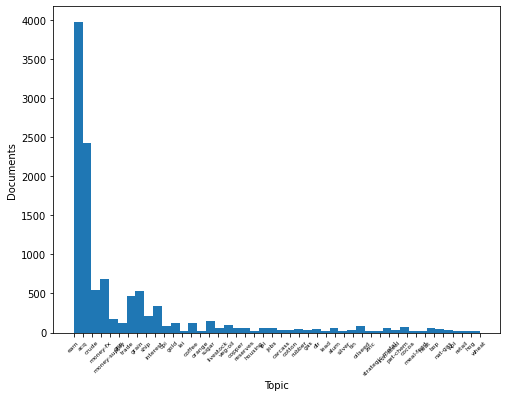

In [73]:
plt.figure(figsize=[8,6])
plt.hist(classes, bins=46)
plt.axis()
plt.xlabel('Topic')
plt.xticks(rotation=45)
plt.rc('xtick',labelsize=6)
plt.ylabel('Documents')


In [0]:
counts=Counter(classes).most_common()

Let's retrieve the word index so that we can "decode" the samples and look at some examples.

In [0]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [76]:
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
for k in [29,30,31,32,33]:
  decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in data[k]])
  print(f"Document {k}:\n{decoded_newswire}","\n")
  print(f"Topic: {classes[k]}\n")

Document 29:
? australia's crude oil tax strategy is probably best ? in terms of a targeted rather than broadly based approach federal resources and energy minister ? evans told a meeting here he told the australian petroleum exploration association apea annual conference there was a prospect of developing a package that would recognise the government's economic priorities while also meeting some of the industry's concerns evans was referring to a nearly completed government review of oil taxation evans said there were plenty of ? where targeted approaches to oil industry taxation had produced good results in recent years these include the reduction in the top marginal crude excise rate on ? bass strait oil found before september 1975 to 80 pct from 87 pct and the waiver of excise on onshore oil announced last september he said the industry through the apea has been calling for the elimination of secondary taxation on oil in order to boost incentives for prospecting against a backgroun

##Look at the frequency of the words in the corpus

In [77]:
indexes = [word for doc in data for word in doc]
print(f"There are {len(indexes)} words in the data corpus.")

There are 1638886 words in the data corpus.


In [78]:
corpus = [reverse_word_index.get(index, '?') for index in indexes]
len(corpus)

1638886

In [79]:
unique_indexes = list(set(indexes))
print(f"There are {len(unique_indexes)} unique words in the data corpus, not including '?'")

There are 9998 unique words in the data corpus, not including '?'


In [80]:
unique_corpus = [reverse_word_index.get(w, '?') for w in unique_indexes]
len(unique_corpus)

9998

The 200 most frequently used words in the corpus:

In [81]:
corpus_frequency = Counter(corpus).most_common()
corpus_frequency[:200]


[('in', 82723),
 ('of', 44880),
 ('said', 42393),
 ('and', 40350),
 ('a', 33157),
 ('mln', 29978),
 ('3', 29956),
 ('for', 29581),
 ('vs', 20141),
 ('dlrs', 16668),
 ('it', 15224),
 ('reuter', 15015),
 ('000', 13329),
 ('1', 12395),
 ('the', 11228),
 ('pct', 11191),
 ('on', 11039),
 ('from', 10755),
 ('is', 10746),
 ('that', 10377),
 ('its', 9345),
 ('cts', 9113),
 ('by', 9022),
 ('at', 8579),
 ('year', 8451),
 ('be', 8311),
 ('with', 8056),
 ('2', 7797),
 ('will', 7627),
 ('was', 7288),
 ('billion', 7100),
 ('he', 7037),
 ('u', 7010),
 ('s', 6588),
 ('net', 6436),
 ('has', 6266),
 ('would', 6157),
 ('an', 5818),
 ('as', 5593),
 ('5', 5553),
 ('not', 5379),
 ('loss', 5369),
 ('4', 5082),
 ('1986', 5081),
 ('company', 4836),
 ('which', 4688),
 ('but', 4574),
 ('this', 4565),
 ('shr', 4383),
 ('last', 4256),
 ('are', 4244),
 ('lt', 4213),
 ('have', 3858),
 ('or', 3838),
 ('6', 3810),
 ('bank', 3756),
 ('7', 3710),
 ('were', 3689),
 ('8', 3654),
 ('had', 3652),
 ('oil', 3646),
 ('trade', 

The 100 least frequently used words in the corpus:

In [82]:
corpus_frequency[:-100:-1]

[('bryson', 7),
 ('steelmakers', 7),
 ('diablo', 7),
 ('haruo', 7),
 ('marcus', 7),
 ('adequately', 7),
 ('anhui', 7),
 ('ross', 7),
 ('inform', 7),
 ('rosenberg', 7),
 ('ousted', 7),
 ('disclosing', 7),
 ('detected', 7),
 ('hardline', 7),
 ('loosen', 7),
 ('biopharmaceutics', 7),
 ('dock', 7),
 ('vetoed', 7),
 ('ideally', 7),
 ('kilowatt', 7),
 ('ica', 7),
 ('decades', 7),
 ('rivals', 7),
 ('leather', 7),
 ('pine', 7),
 ('sake', 7),
 ('lac', 7),
 ('vigorous', 7),
 ('thick', 7),
 ('electro', 7),
 ('getty', 7),
 ('meinhardt', 7),
 ('dockworkers', 7),
 ('siddeley', 7),
 ('chen', 7),
 ('schweizerische', 7),
 ('ian', 7),
 ('irwin', 7),
 ('older', 7),
 ('arose', 7),
 ('mad', 7),
 ('crepe', 7),
 ('monfort', 7),
 ('diminishing', 7),
 ('signalling', 7),
 ('inefficient', 7),
 ('warmer', 7),
 ('cardiovascular', 7),
 ('guillaume', 7),
 ("champlin's", 7),
 ('fuelled', 7),
 ('alongside', 7),
 ('conform', 7),
 ('sheets', 7),
 ('ralph', 7),
 ('reallocated', 7),
 ('heaviest', 7),
 ('staged', 7),
 ('20

In [83]:
data_unique = [list(set(d)) for d in data]
len(data_unique)

11228

In [84]:
ones = [word for word, freq in Counter(corpus).items() if freq == 1]
print(f"There are {len(ones)} words that only occur once in the corpus")

There are 0 words that only occur once in the corpus


In [85]:
sevens = [word for word, freq in Counter(corpus).items() if freq == 7]
print(f"There are {len(sevens)} words that only occur 7 times in the corpus")

There are 616 words that only occur 7 times in the corpus


In [86]:
Counter(Counter(corpus).values()).most_common(20)

[(7, 616),
 (8, 578),
 (9, 451),
 (10, 380),
 (11, 379),
 (12, 346),
 (13, 288),
 (15, 271),
 (14, 266),
 (16, 258),
 (18, 251),
 (17, 224),
 (20, 210),
 (19, 186),
 (21, 180),
 (22, 163),
 (24, 142),
 (26, 131),
 (23, 131),
 (25, 127)]

In [87]:
import pandas as pd
df2 = pd.DataFrame(Counter(Counter(corpus).values()).most_common(),
                   columns=['frequency', 'num of words'])
df2.head(20)

,frequency,num of words
0,7,616
1,8,578
2,9,451
3,10,380
4,11,379
5,12,346
6,13,288
7,15,271
8,14,266
9,16,258


In [88]:
df2.tail(20)

,frequency,num of words
799,470,1
800,336,1
801,266,1
802,282,1
803,532,1
804,628,1
805,366,1
806,539,1
807,619,1
808,268,1


In [89]:
df2['perc'] = round(df2['num of words']*100/df2['num of words'].sum(),4)
df2.sort_values(by='frequency',).head(50)

,frequency,num of words,perc
0,7,616,6.1612
1,8,578,5.7812
2,9,451,4.5109
3,10,380,3.8008
4,11,379,3.7908
5,12,346,3.4607
6,13,288,2.8806
8,14,266,2.6605
7,15,271,2.7105
9,16,258,2.5805


###Histogram based on number of words in each document and a histogram of the frequency of the unique words in the corpus

In [90]:
doc_sizes = ([len(lst) for lst in data]) #number of words per doc
print(f"Number of words in the documents: {min(doc_sizes)} to {max(doc_sizes)}")

Number of words in the documents: 2 to 2376


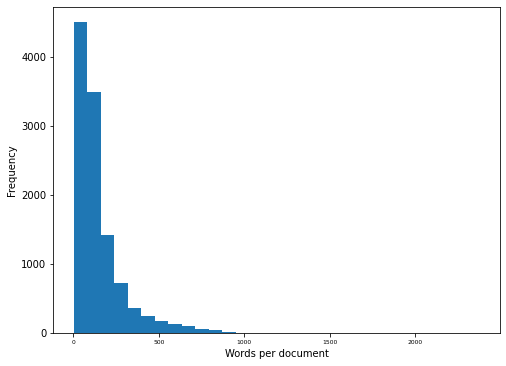

In [91]:
plt.figure(figsize=[8,6])
plt.hist(doc_sizes, bins=30)

plt.axis()
plt.xlabel('Words per document')
plt.ylabel('Frequency')
plt.rc('xtick',labelsize=10)

There is a long tail in the histgram. Limit to documents with 800 or fewer words:

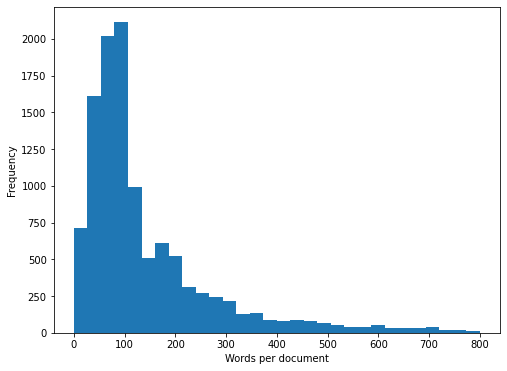

In [92]:
plt.figure(figsize=[8,6])
plt.hist(doc_sizes, bins=30, range = (0,800))

plt.axis()
plt.xlabel('Words per document')
plt.ylabel('Frequency')
plt.rc('xtick',labelsize=10)

###Limit the corpus based on the findings of the EDA

Unique words to include:

In [0]:
skip_top = 10
voc_size = 10000

Maximum words per document:

In [94]:
maxlen = int(np.percentile(doc_sizes, 90))
print(f"80th percentile of document size: {maxlen}")

80th percentile of document size: 315


##Import the data using the new restrictions

The data is restricted to the 10,000 most frequently occurring words in the data, after skipping the 10 most frequently occurring words.

In [0]:
# https://keras.io/datasets/#reuters-newswire-topics-classification
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) =\
reuters.load_data(test_split=0.20, num_words=voc_size, skip_top=skip_top, maxlen=maxlen)

In [96]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(8083, 8083, 2021, 2021)

Each example is a list of integers (word indices):

In [97]:
print(train_data[1]) 

[2, 3267, 699, 3434, 2295, 56, 2, 7511, 2, 56, 3906, 1073, 81, 2, 1198, 57, 366, 737, 132, 20, 4093, 2, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 2, 2, 10, 241, 16, 855, 129, 231, 783, 2, 2, 587, 2295, 2, 2, 775, 2, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


The document with the most unique words in the training data has 131 unique words

In [98]:
max([len(set(lst)) for lst in train_data])

190

Let's retrieve the word index so that we can "decode" the samples and look at some examples.

In [99]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[42]])
decoded_newswire

"? bank ? japan governor satoshi sumita ? he welcomed monday's u s ? west german joint confirmation ? their commitment ? ? louvre accord sumita ? ? a statement that world ? were excessively concerned about ? economic future ? bank ? japan will continue ? adhere ? a system ? policy coordination based upon ? louvre accord ? february he ? ? accord called for stability ? foreign exchange rates exchange rates generally are ? stability ? ? economies ? industrialised nations are heading for a steady recovery he ? reuter 3"

In [100]:
len(decoded_newswire.split()) # number words in the newswire document

94

In [101]:
decoded_newswire.split()[:7]   # first 7 words in the document

['?', 'bank', '?', 'japan', 'governor', 'satoshi', 'sumita']

In [102]:
len(train_data[1])  # The list of encodings is the same size as the number of words in the document

56

In [103]:
train_data[1][:7] # The encodings of the first 7 words in the document. Again, 2 = "unknown"

[2, 3267, 699, 3434, 2295, 56, 2]

##Reducing the number of topics

---



In [104]:
from collections import Counter
len(Counter(list(train_labels)).keys()) # There are 46 topics

46

In [105]:
# The ten most common train labels
train_label_tuples = \
Counter(list(train_labels)).most_common(15) # if we keep the top nine we get the same training and test labels
train_label_tuples

[(3, 3065),
 (4, 1789),
 (19, 466),
 (1, 371),
 (16, 345),
 (11, 283),
 (20, 222),
 (13, 158),
 (8, 115),
 (10, 109),
 (25, 87),
 (9, 77),
 (21, 68),
 (18, 62),
 (2, 62)]

In [106]:
# The ten most common test labels
test_label_tuples = \
Counter(list(test_labels)).most_common(15) # if we keep the top 9 we get the same training and test labels
test_label_tuples

[(3, 796),
 (4, 441),
 (19, 98),
 (1, 86),
 (16, 77),
 (11, 63),
 (20, 55),
 (13, 33),
 (8, 32),
 (25, 31),
 (10, 26),
 (9, 24),
 (21, 18),
 (2, 18),
 (24, 18)]

Note that the top 12 topics in the training and test datasets are the same, even though they are in slightly different orders

In [107]:
# Separate the labels from their frequencies
topics_train_tpl, train_freq = zip(*Counter(list(train_labels)).most_common(11))
topics_train_tpl

(3, 4, 19, 1, 16, 11, 20, 13, 8, 10, 25)

In [108]:
train_freq

(3065, 1789, 466, 371, 345, 283, 222, 158, 115, 109, 87)

In [109]:
topics_test_tpl, test_freq = zip(*Counter(list(test_labels)).most_common(11))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 13, 8, 25, 10)

In [110]:
sum(test_freq) # number of test values in top 11

1738

In [111]:
sum(train_freq)  # number of training values in top 11

7010

In [0]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels)
 if y in topics_train_tpl))

In [0]:
import numpy as np
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [114]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7010, 7010)

In [0]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [0]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [117]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1738, 1738)

In [118]:
Counter(train_labels_sm) # another sanity check on the the new smaller set of training labels. See In [13].

Counter({1: 371,
         3: 3065,
         4: 1789,
         8: 115,
         10: 109,
         11: 283,
         13: 158,
         16: 345,
         19: 466,
         20: 222,
         25: 87})

In [119]:
Counter(test_labels_sm) # another sanity check on the the new smaller set of test labels. See In [14].

Counter({1: 86,
         3: 796,
         4: 441,
         8: 32,
         10: 26,
         11: 63,
         13: 33,
         16: 77,
         19: 98,
         20: 55,
         25: 31})

###Relabel the 11 most frequent topics, so that we can use 11 nodes in our output layer


Modify the labels to make them sequential

In [120]:
# first define relabeling function
keys = Counter(test_labels_sm).keys()
conv = dict(zip(sorted(keys),range(0,11)))
conv

{1: 0, 3: 1, 4: 2, 8: 3, 10: 4, 11: 5, 13: 6, 16: 7, 19: 8, 20: 9, 25: 10}

In [121]:
# next create the new labels
train_labels_sm2 = [conv[l] for l in train_labels_sm]
test_labels_sm2 = [conv[l] for l in test_labels_sm]
print(Counter(train_labels_sm2))  # Looks like they were relabeled correctly
print(Counter(test_labels_sm2))   # Looks like they were relabeled correctly

Counter({1: 3065, 2: 1789, 8: 466, 0: 371, 7: 345, 5: 283, 9: 222, 6: 158, 3: 115, 4: 109, 10: 87})
Counter({1: 796, 2: 441, 8: 98, 0: 86, 7: 77, 5: 63, 9: 55, 6: 33, 3: 32, 10: 31, 4: 26})


In [0]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [123]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{0: 'cocoa',
 6: 'copper',
 11: 'trade',
 12: 'reserves',
 13: 'ship',
 14: 'cotton',
 19: 'money-fx',
 23: 'alum',
 25: 'gold',
 26: 'tin',
 28: 'livestock',
 30: 'ipi',
 31: 'iron-steel',
 34: 'jobs',
 37: 'zinc'}

In [124]:
# get the dictionary for our smaller data set
idx_to_class_sm = {k:v for k,v in idx_to_class.items() if k in topics_test_tpl}
idx_to_class_sm 

{1: 'grain',
 3: 'earn',
 4: 'acq',
 8: 'money-supply',
 10: 'sugar',
 11: 'trade',
 13: 'ship',
 16: 'crude',
 19: 'money-fx',
 20: 'interest',
 25: 'gold'}

In [125]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_sm[11]])
decoded_newswire

'? lt international thomson organisation ltd ? it will report financial results ? u s funds rather than sterling beginning from jan 1 1987 it ? ? change will not be applied retroactively ? prior financial periods ? company ? as a result ? recent investments most ? its assets now are located ? ? united states reuter 3'

In [126]:
idx_to_class_sm[train_labels_sm[11]]   # checking the dictionary...topic seems to be right

'earn'